In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import re
from sklearn.cluster import KMeans

startRampPath = 'data/BLM/start_ramp'
startAdjustPath = 'data/BLM/start_adjust'
startSqueezePath = 'data/BLM/start_squeeze'
flatTopPath = 'data/BLM/flat_top'

In [2]:
def getRowWithBlmMax(fill):
    """
    Parameters
        fill : DataFrame -- DataFrame loaded from the BLM data fill file, without timestamp column
    Returns
        DataFrame with row with the max BLM value in the provided data
    """
    maxes = fill.max(axis=1)  # row index -> max for that row
    maxOverallIdx = maxes.idxmax() # row index where max overall in fill can be found
    
    return fill.loc[maxOverallIdx] # row containing max overall

In [3]:
#TODO rename to filenames - not files
def loadFillFiles(phasePath):
    files = sorted(os.listdir(phasePath))
    files = [file for file in files if file.endswith('.txt')] # keep only text files - filter out files such as desktop.ini
    print(files) # To confirm that fills have been loaded in chronological order
    
    return files

In [4]:
def getMergedPhaseLosses(phasePath, maxFills):
    """
    Parameters
        phasePath : string - path containing fill files for a particular phase
        #TODO check for trailing / - or see if there are python function path functions that handle this for you
        maxFills : int - maximum number of fills to process.  -1 to process all fill files.
    Returns
        DataFrame with row with the max BLM value in the provided data
    """
    files = loadFillFiles(phasePath)
    phaseLosses = pd.DataFrame() # in each fill the row with the highest loss is chosen and appended to this DataFrame

    maxLossRows = []
    for i, file in enumerate(files):
        if i == maxFills:
            break

        # load fill file into a DataFrame
        fill = pd.read_csv(phasePath + '/' + file, sep=' ', header=None)
        # Delete first column (contains timestamps)
        fill = fill.drop(columns=0)
        # Extract the fill number from the filename (used eventually as the key for the row extracted from this fill)
        fillNo = re.search(r'\d+', file).group()

        # extract from the fill the row with the maximum loss
        rowWithMaxLoss = getRowWithBlmMax(fill)
        rowWithMaxLoss.name = fillNo
        maxLossRows.append(rowWithMaxLoss)
        
    phaseLosses = phaseLosses.append(maxLossRows)
        
    blmLabels = np.genfromtxt('data/blm_labels.txt', dtype='str')
    beam1BlmLabels = np.genfromtxt('data/beam1_blm_labels.txt', dtype='str')
    beam2BlmLabels = np.genfromtxt('data/beam2_blm_labels.txt', dtype='str')
    logicalBlmLabels = np.genfromtxt('data/logical_blm_labels.txt', dtype='str')

    phaseLosses.columns = blmLabels

    # Separate beam 1 losses and beam 2 losses
    beam1PhaseLosses = phaseLosses.filter(items=beam1BlmLabels); 
    beam2PhaseLosses = phaseLosses.filter(items=beam2BlmLabels);

    beam1PhaseLosses.columns = logicalBlmLabels 
    beam2PhaseLosses.columns = logicalBlmLabels

    # merge beam 1 losses and beam 2 losses under the same logical BLM labels
    mergedPhaseLosses = pd.concat([beam1PhaseLosses, beam2PhaseLosses], keys=['B1', 'B2'])
    
    return mergedPhaseLosses

In [5]:
maxFills = -1
startRampLosses = getMergedPhaseLosses(startRampPath, maxFills)
startAdjustLosses = getMergedPhaseLosses(startAdjustPath, maxFills)
startSqueezeLosses = getMergedPhaseLosses(startSqueezePath, maxFills)
flatTopLosses = getMergedPhaseLosses(flatTopPath, maxFills)


['Fill_6925_start_ramp.txt', 'Fill_6927_start_ramp.txt', 'Fill_6928_start_ramp.txt', 'Fill_6929_start_ramp.txt', 'Fill_6931_start_ramp.txt', 'Fill_6938_start_ramp.txt', 'Fill_6939_start_ramp.txt', 'Fill_6940_start_ramp.txt', 'Fill_6942_start_ramp.txt', 'Fill_6944_start_ramp.txt', 'Fill_6946_start_ramp.txt', 'Fill_6952_start_ramp.txt', 'Fill_6953_start_ramp.txt', 'Fill_6956_start_ramp.txt', 'Fill_6957_start_ramp.txt', 'Fill_6960_start_ramp.txt', 'Fill_6961_start_ramp.txt', 'Fill_6962_start_ramp.txt', 'Fill_6963_start_ramp.txt', 'Fill_6964_start_ramp.txt', 'Fill_6966_start_ramp.txt', 'Fill_6967_start_ramp.txt', 'Fill_6972_start_ramp.txt', 'Fill_6973_start_ramp.txt', 'Fill_6974_start_ramp.txt', 'Fill_6975_start_ramp.txt', 'Fill_6976_start_ramp.txt', 'Fill_6978_start_ramp.txt', 'Fill_6979_start_ramp.txt', 'Fill_6980_start_ramp.txt', 'Fill_6981_start_ramp.txt', 'Fill_6984_start_ramp.txt', 'Fill_6988_start_ramp.txt', 'Fill_6989_start_ramp.txt', 'Fill_6990_start_ramp.txt', 'Fill_6991_start_ra

['Fill_6925_flat_top.txt', 'Fill_6927_flat_top.txt', 'Fill_6929_flat_top.txt', 'Fill_6931_flat_top.txt', 'Fill_6938_flat_top.txt', 'Fill_6939_flat_top.txt', 'Fill_6940_flat_top.txt', 'Fill_6942_flat_top.txt', 'Fill_6944_flat_top.txt', 'Fill_6946_flat_top.txt', 'Fill_6952_flat_top.txt', 'Fill_6953_flat_top.txt', 'Fill_6956_flat_top.txt', 'Fill_6957_flat_top.txt', 'Fill_6960_flat_top.txt', 'Fill_6961_flat_top.txt', 'Fill_6962_flat_top.txt', 'Fill_6963_flat_top.txt', 'Fill_6964_flat_top.txt', 'Fill_6966_flat_top.txt', 'Fill_6967_flat_top.txt', 'Fill_6972_flat_top.txt', 'Fill_6973_flat_top.txt', 'Fill_6974_flat_top.txt', 'Fill_6975_flat_top.txt', 'Fill_6976_flat_top.txt', 'Fill_6978_flat_top.txt', 'Fill_6979_flat_top.txt', 'Fill_6980_flat_top.txt', 'Fill_6981_flat_top.txt', 'Fill_6984_flat_top.txt', 'Fill_6988_flat_top.txt', 'Fill_6989_flat_top.txt', 'Fill_6990_flat_top.txt', 'Fill_6991_flat_top.txt', 'Fill_6993_flat_top.txt', 'Fill_6995_flat_top.txt', 'Fill_6998_flat_top.txt', 'Fill_7001_

In [173]:
def compareKMeansWithGroundTruth(labels, losses):
    for clusterNo in range(0, 2):
        b1Count = 0
        b2Count = 0
        indicesOfLossesInCluster = np.where(kmeans.labels_ == clusterNo)[0]
        lossesInClusterCount = len(indicesOfLossesInCluster)
        
        for key in losses.index.values[indicesOfLossesInCluster]:
            if key[0] == 'B1':
                b1Count = b1Count + 1
            elif key[0] == 'B2':
                b2Count = b2Count + 1
            else:
                print("Key error - neither B1 nor B2 in key {}".format(key))
                
        assert b1Count + b2Count == lossesInClusterCount
        
        if b1Count == 0:
            print('Cluster', clusterNo, 'has only B2 losses. All',  b2Count, '/', lossesInClusterCount)
        elif b2Count == 0:
            print('Cluster', clusterNo, 'has only B1 losses. All', b1Count, '/', lossesInClusterCount)
        elif (b1Count > b2Count):
            print('Cluster', clusterNo, 'has majority B1 losses. But', b2Count, '/', lossesInClusterCount, 'are B2 losses.')
        elif (b2Count > b1Count):
            print('Cluster', clusterNo, 'has majority B2 losses. But', b1Count, '/', lossesInClusterCount, 'are B1 losses.')
        else:
            print('Cluster', clusterNo, 'has equal number B1, B2 losses:', b1Count, '/', lossesInClusterCount)        

In [174]:
# TODO figure out if you really need to reinstantiate KMeans every time - will fit consider previous data points?
kmeans = KMeans(n_clusters = 2)
kmeans.fit(startRampLosses)
print("start_ramp Cluster memberships:\n{}".format(kmeans.labels_))
# find whether majority of points in cluster 1 are B1 or B2. do the same for cluster 2.
compareKMeansWithGroundTruth(kmeans.labels_, startRampLosses)
# kmeans = KMeans(n_clusters = 2)
kmeans.fit(startAdjustLosses)
print("start_adjust Cluster memberships:\n{}".format(kmeans.labels_))
compareKMeansWithGroundTruth(kmeans.labels_, startAdjustLosses)
# kmeans = KMeans(n_clusters = 2)
kmeans.fit(startSqueezeLosses)
print("start_squeeze Cluster memberships:\n{}".format(kmeans.labels_))
compareKMeansWithGroundTruth(kmeans.labels_, startSqueezeLosses)
# kmeans = KMeans(n_clusters = 2)
kmeans.fit(flatTopLosses)
print("flat_top Cluster memberships:\n{}".format(kmeans.labels_))
compareKMeansWithGroundTruth(kmeans.labels_, flatTopLosses)

start_ramp Cluster memberships:
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0
 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0
 1 1 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 0 0 0 0 1]
Cluster 0 has majority B1 losses. But 40 / 87 are B2 losses.
Cluster 1 has majority B2 losses. But 104 / 215 are B1 losses.
start_adjust Cluster memberships:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1

<IPython.core.display.Javascript object>


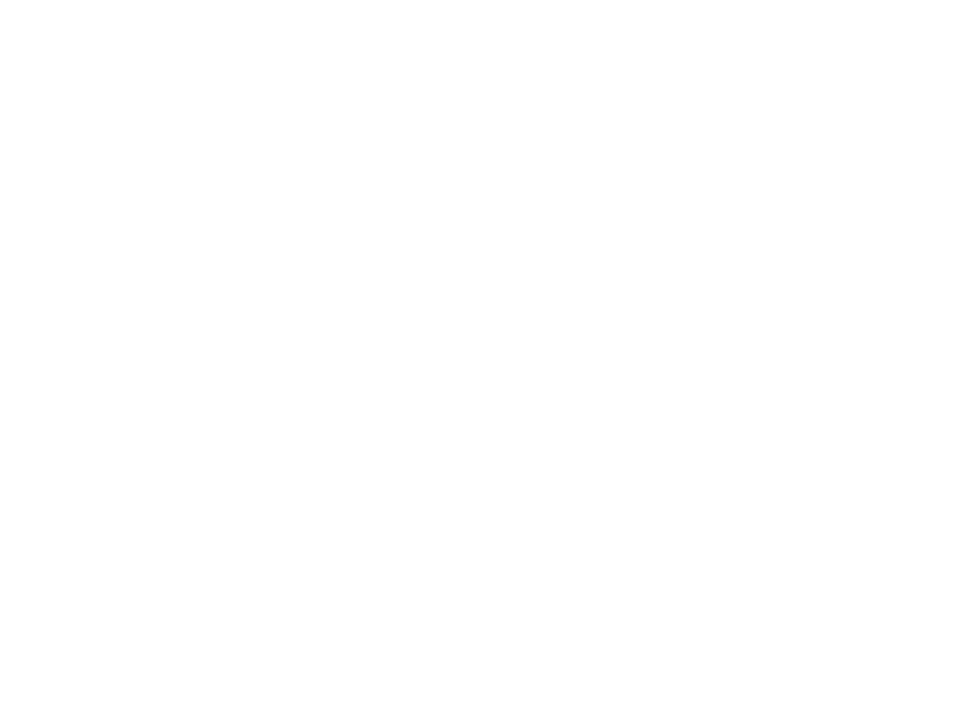

Text(0, 0.5, 'Loss')

In [7]:
# Data
df = pd.DataFrame({
    'B1': startRampLosses.loc['B1']['TCP.C6x7'],
    'B2': startRampLosses.loc['B2']['TCP.C6x7']
})
 
# multiple line plot
plt.figure()
plt.plot('B1', data=df, marker='x', color='red')
plt.plot('B2', data=df, marker='x', color='black')
plt.legend()
plt.title('Plot of the loss registered in TCP.C6x7 against the fill number')
plt.xlabel('Fill')
plt.ylabel('Loss')


<IPython.core.display.Javascript object>


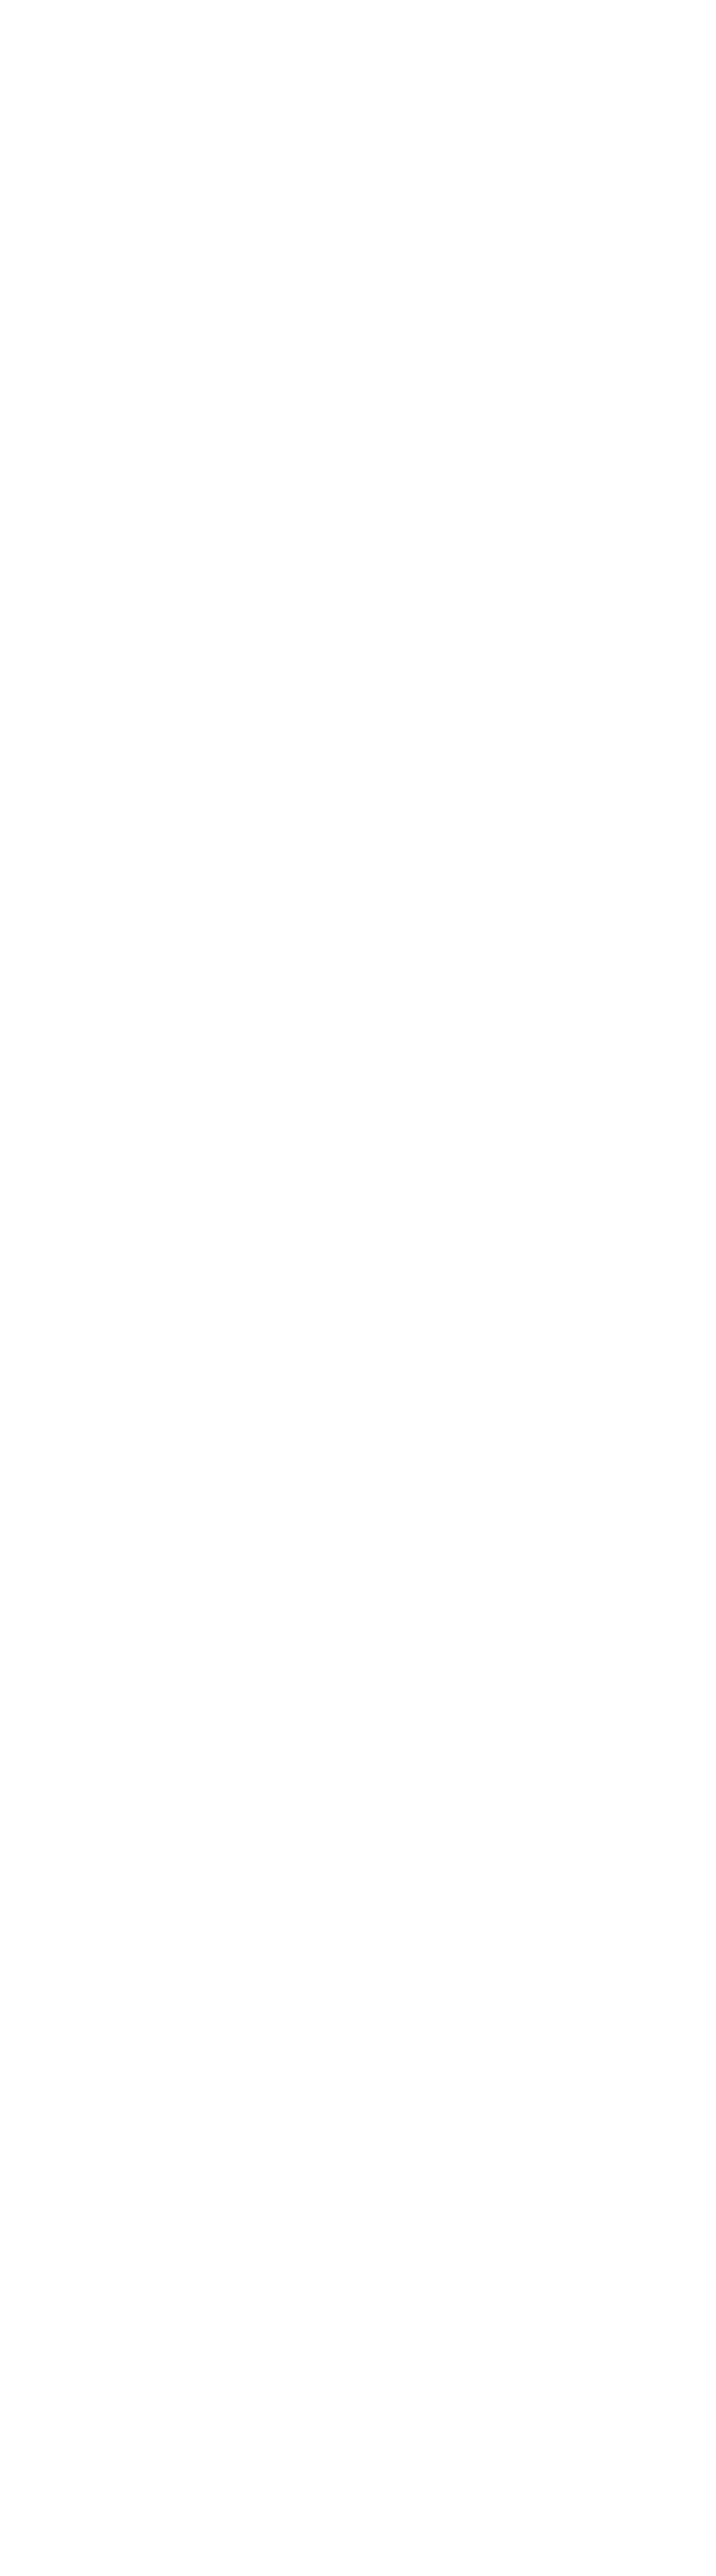

In [8]:
plt.figure(figsize=(10, 36))
ncols = 3;
nrows = math.ceil(startRampLosses.shape[1] / ncols)
i = 1;
for column in startRampLosses:
    # Data
    df = pd.DataFrame({
        'B1': startRampLosses.loc['B1'][column],
        'B2': startRampLosses.loc['B2'][column]
    })
 
    plt.subplot(nrows, ncols, i)
    plt.yscale('log')
    plt.plot('B1', data=df, marker='x', color='red')
    plt.plot('B2', data=df, marker='x', color='black')
    plt.title(column)

    
    i = i + 1
    

plt.tight_layout()

In [9]:
#To get Euclidean distance between the BLM vectors for beam 1 and beam 2
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

startRampDistance = pd.Series(
    cdist(startRampLosses.loc['B1'].values, startRampLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=startRampLosses.loc['B1'].index)  # in order to preserve the fill numbers for x-axis of the euclidean distance plot
startAdjustDistance = pd.Series(
    cdist(startAdjustLosses.loc['B1'].values, startAdjustLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=startAdjustLosses.loc['B1'].index)
startSqueezeDistance = pd.Series(
    cdist(startSqueezeLosses.loc['B1'].values, startSqueezeLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=startSqueezeLosses.loc['B1'].index)
flatTopDistance = pd.Series(
    cdist(flatTopLosses.loc['B1'].values, flatTopLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=flatTopLosses.loc['B1'].index)

#getting diagonal to get the euclidean distance of pairs of vectors we care about (i.e. corresponding rows)
#eg. euclidean distance between row 0 of B1 values, row 0 of B2 values; euclidean distance between row 1 of B1 values,
#row 1 of B2 values, and so on.

#to confirm values are correct:
# print(distance)
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[0], mergedPhaseLosses.loc['B2'].iloc[0]))
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[1], mergedPhaseLosses.loc['B2'].iloc[1]))
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[2], mergedPhaseLosses.loc['B2'].iloc[2]))


<IPython.core.display.Javascript object>


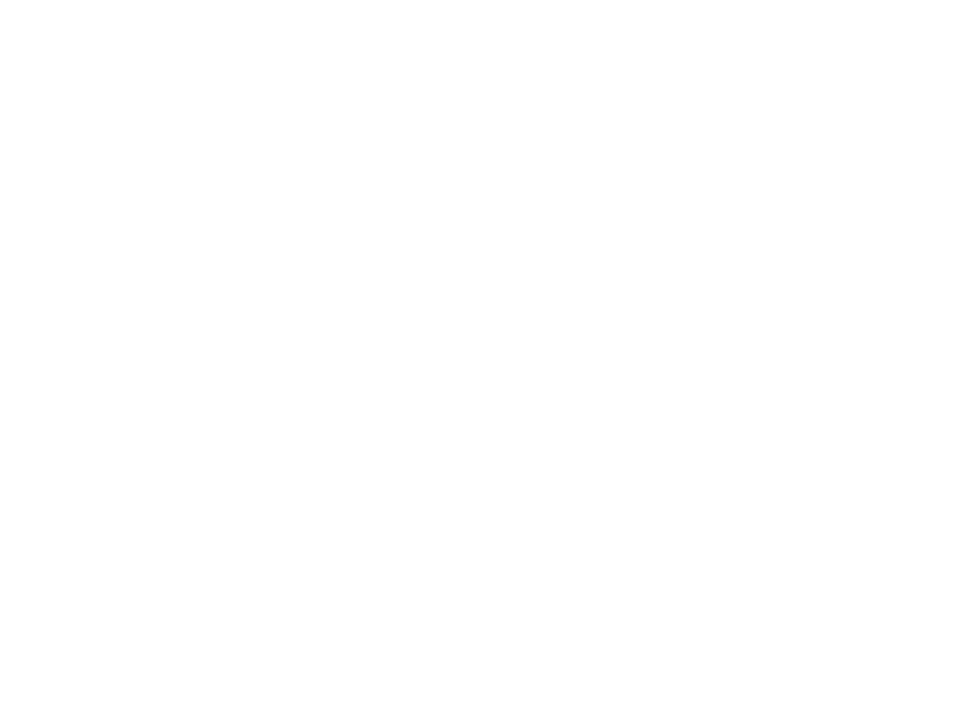

Text(0, 0.5, 'Euclidean distance')

In [10]:
# To plot Euclidean between the vectors (TCP, TCSG, ...) for beam 1 and beam 2
# Data
df = pd.DataFrame({
    'start_ramp': startRampDistance,
    'start_adjust': startAdjustDistance,
    'start_squeeze': startSqueezeDistance,
    'flat_top': flatTopDistance
})
 
# multiple line plot
plt.figure()
plt.yscale('log')
plt.plot('start_ramp', data=df, marker='x', color='black')
plt.plot('start_adjust', data=df, marker='x', color='red')
plt.plot('start_squeeze', data=df, marker='x', color='yellow')
plt.plot('flat_top', data=df, marker='x', color='blue')
plt.legend()
plt.title('Plot of Euclidean distance between the BLM vectors of the two beams')
plt.xlabel('Fill')
plt.ylabel('Euclidean distance')

In [21]:
def scatterPlotLosses(mergedLosses, title=""):
    %matplotlib notebook

    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = mergedLosses.loc['B1'][mergedLosses.columns[0]]
    ys = mergedLosses.loc['B1'][mergedLosses.columns[1]]
    zs = mergedLosses.loc['B1'][mergedLosses.columns[2]]
    ax.scatter(xs, ys, zs, c='red', label='B1')

    xs = mergedLosses.loc['B2'][mergedLosses.columns[0]]
    ys = mergedLosses.loc['B2'][mergedLosses.columns[1]]
    zs = mergedLosses.loc['B2'][mergedLosses.columns[2]]
    ax.scatter(xs, ys, zs, c='black', label='B2')

    ax.set_xlabel(mergedLosses.columns[0])
    ax.set_ylabel(mergedLosses.columns[1])
    ax.set_zlabel(mergedLosses.columns[2])
    plt.legend()
    plt.title(title)
    plt.show()

<IPython.core.display.Javascript object>


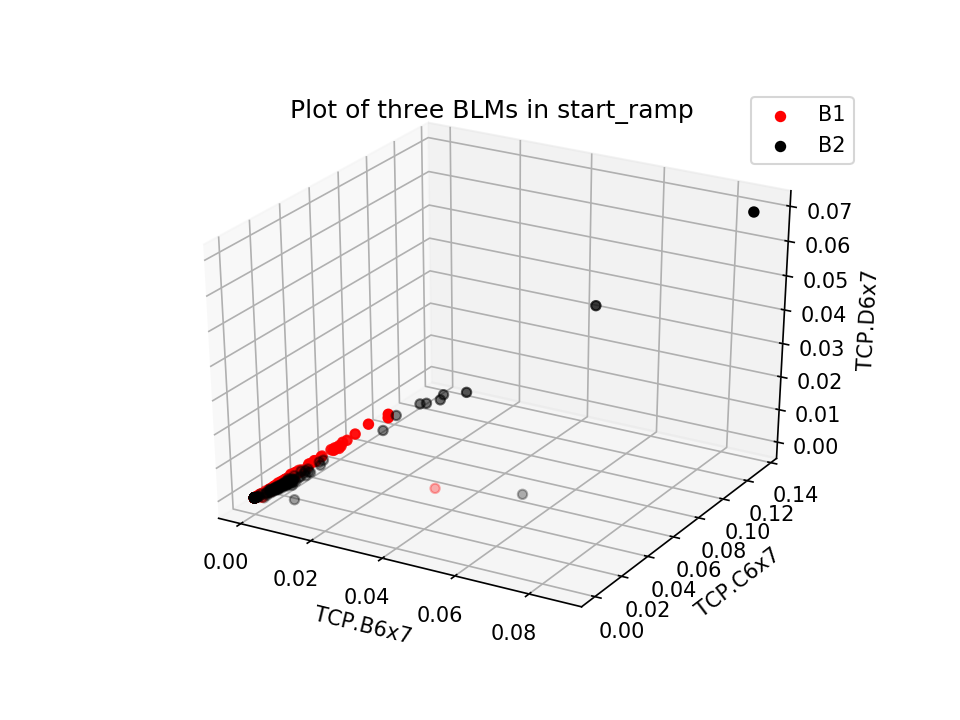

In [22]:
# 3D-plot - each axis is a different BLM.

scatterPlotLosses(startRampLosses[['TCP.B6x7', 'TCP.C6x7', 'TCP.D6x7']], "Plot of three BLMs in start_ramp")

In [13]:
# Min-max scale the features (i.e the BLM values)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

startRampLossesScaled = pd.DataFrame().reindex_like(startRampLosses)
startSqueezeLossesScaled = pd.DataFrame().reindex_like(startSqueezeLosses)
startAdjustLossesScaled = pd.DataFrame().reindex_like(startAdjustLosses)
flatTopLossesScaled = pd.DataFrame().reindex_like(flatTopLosses)

startRampLossesScaled.loc[:] = scaler.fit_transform(startRampLosses.loc[:])
startSqueezeLossesScaled.loc[:] = scaler.fit_transform(startSqueezeLosses.loc[:])
startAdjustLossesScaled.loc[:] = scaler.fit_transform(startAdjustLosses.loc[:])
flatTopLossesScaled.loc[:] = scaler.fit_transform(flatTopLosses.loc[:])

#TODO should I use RobustScaler, due to the presence of outliers?

<IPython.core.display.Javascript object>


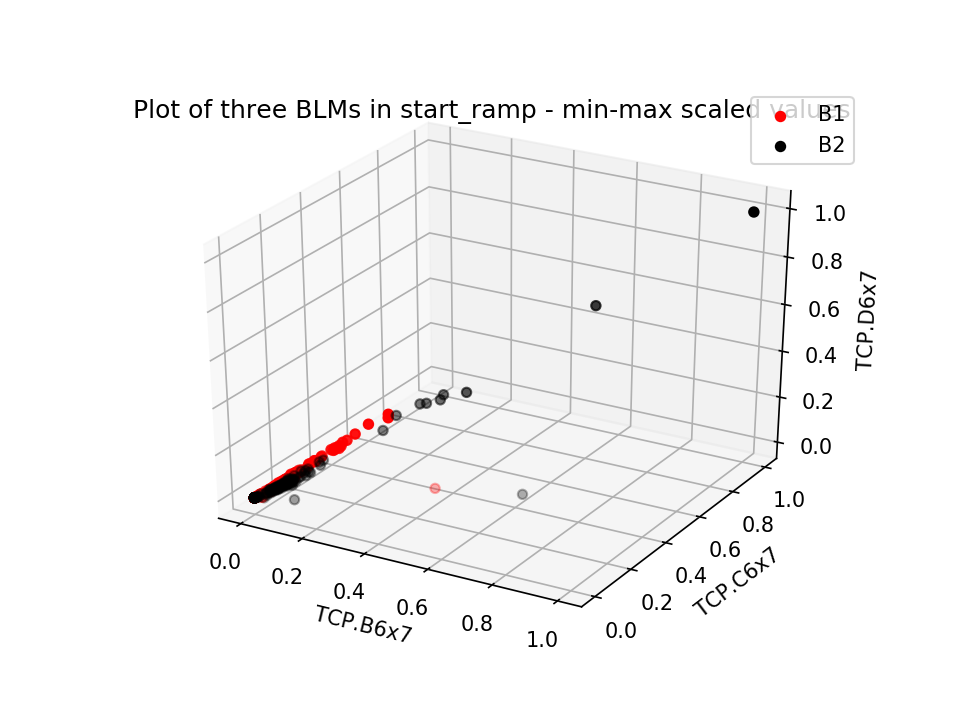

In [23]:
# 3D-plot - scaled BLM values

scatterPlotLosses(startRampLossesScaled[['TCP.B6x7', 'TCP.C6x7', 'TCP.D6x7']], "Plot of three BLMs in start_ramp - min-max scaled values")

In [15]:
# PCA

from sklearn.decomposition import PCA

pca = PCA()  # n_components not set => keep all components
pca.fit(startRampLosses)

#TODO print the BLM names too - i.e. startRampLosses.columns (maybe make a quick dataframe to illustrate)
print('Explained variance ratio of each BLM (sums to 1):')
print(pca.explained_variance_ratio_)

pca = PCA(n_components=3)
startRampLossesPCA = pd.DataFrame(data=pca.fit_transform(startRampLossesScaled), index=startRampLossesScaled.index, columns=['PCA1', 'PCA2', 'PCA3'])
startSqueezeLossesPCA = pd.DataFrame(data=pca.fit_transform(startSqueezeLossesScaled), index=startSqueezeLossesScaled.index, columns=['PCA1', 'PCA2', 'PCA3'])
startAdjustLossesPCA = pd.DataFrame(data=pca.fit_transform(startAdjustLossesScaled), index=startAdjustLossesScaled.index, columns=['PCA1', 'PCA2', 'PCA3'])
flatTopLossesPCA = pd.DataFrame(data=pca.fit_transform(flatTopLossesScaled), index=flatTopLossesScaled.index, columns=['PCA1', 'PCA2', 'PCA3'])

Explained variance ratio of each BLM (sums to 1):
[8.27540592e-01 1.46159232e-01 1.86346815e-02 3.36846942e-03
 1.94226012e-03 1.06639516e-03 6.53206466e-04 2.53880422e-04
 1.00396460e-04 9.81258384e-05 8.03456978e-05 4.70188304e-05
 1.97950837e-05 1.20577254e-05 6.92388776e-06 5.13676094e-06
 3.20130867e-06 2.32546738e-06 1.42680469e-06 1.38191447e-06
 1.06255906e-06 7.00503954e-07 6.29898219e-07 3.82951302e-07
 1.96936212e-07 6.73908938e-08 3.39596663e-08 2.97770989e-08
 2.35552746e-08 9.54120175e-09 4.39069431e-09 2.53968203e-09
 8.95590932e-10 6.46846010e-10 4.63610243e-10 1.81688877e-10
 1.56487404e-10 6.44261786e-11 3.53659009e-11 1.71075734e-11
 1.18512275e-11 4.79607305e-12 3.10072797e-12 1.48377693e-12
 6.79978137e-13 5.33097976e-13 2.67973259e-13]


<IPython.core.display.Javascript object>


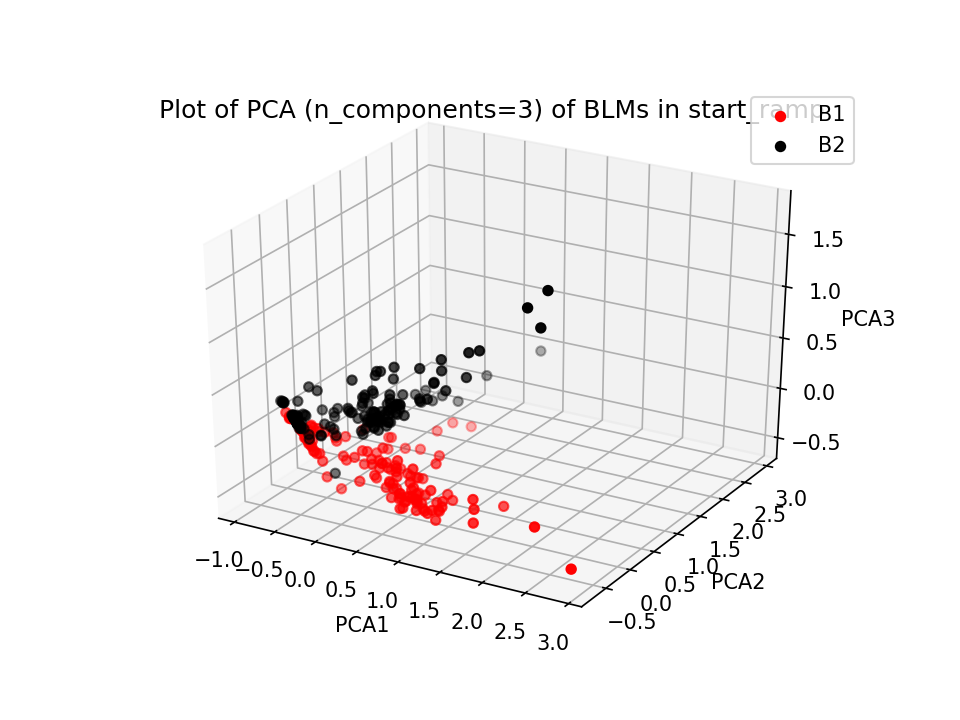

In [24]:
scatterPlotLosses(startRampLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_ramp")

<IPython.core.display.Javascript object>


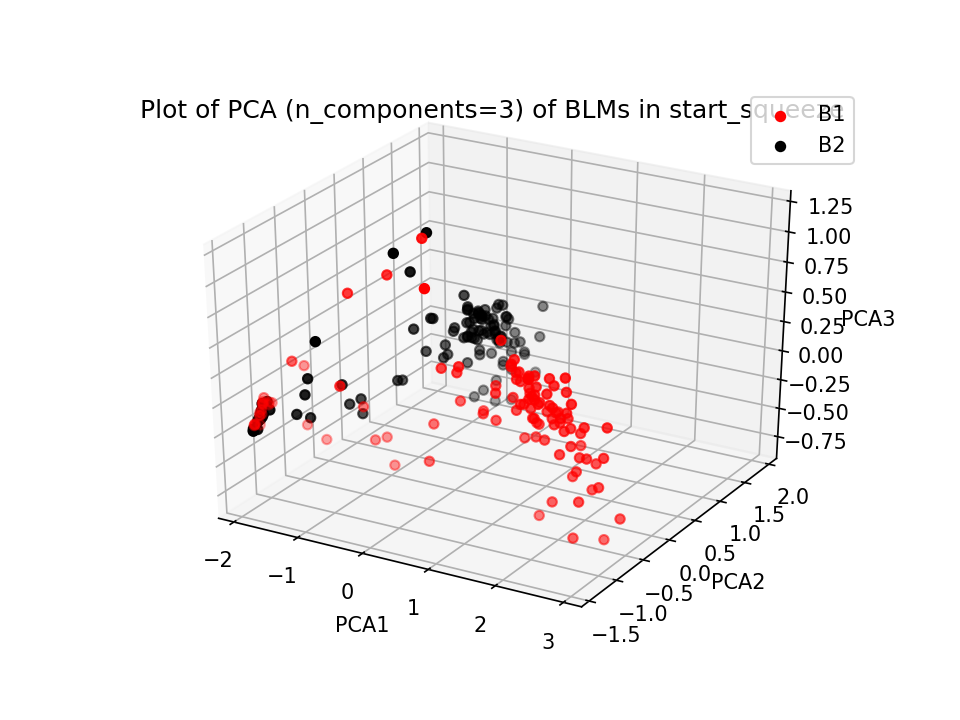

In [25]:
scatterPlotLosses(startSqueezeLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_squeeze")

<IPython.core.display.Javascript object>


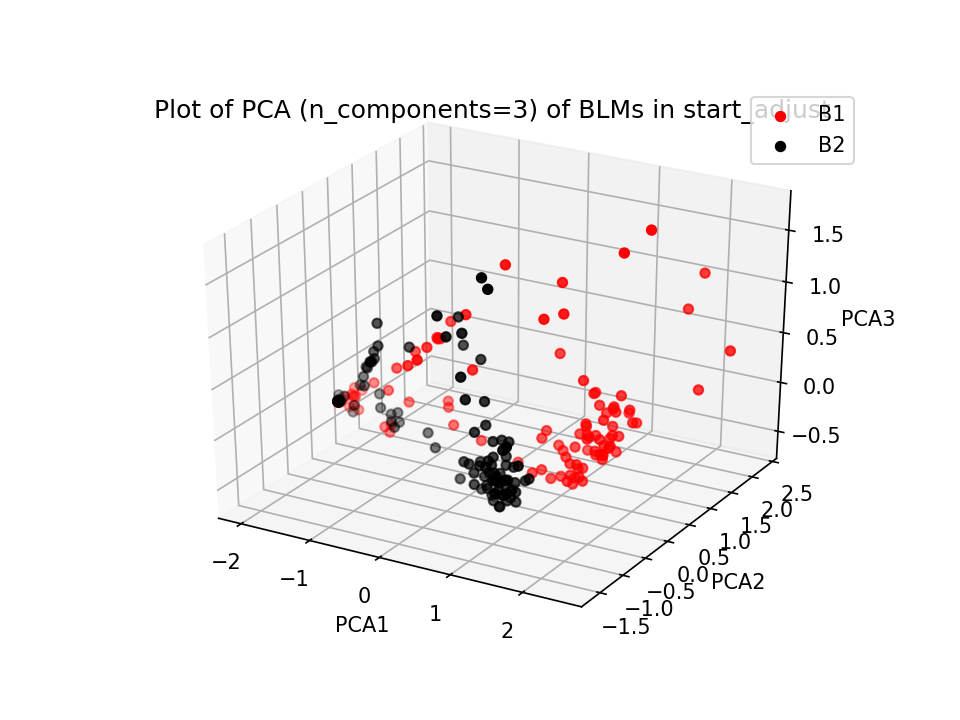

In [26]:
scatterPlotLosses(startAdjustLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_adjust")

<IPython.core.display.Javascript object>


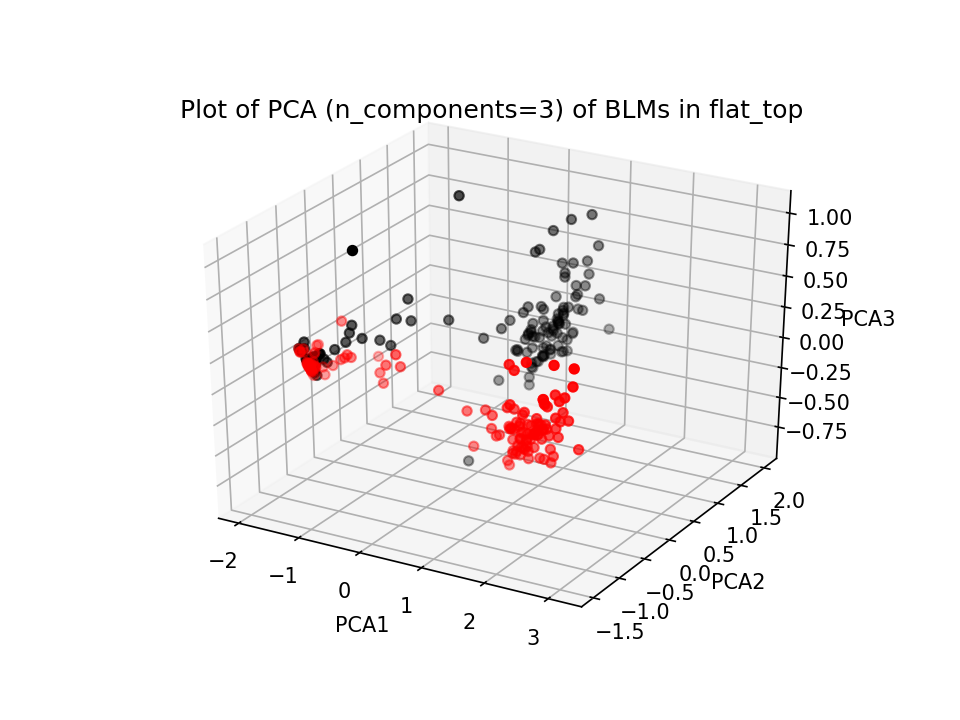

In [19]:
scatterPlotLosses(flatTopLossesPCA, "Plot of PCA (n_components=3) of BLMs in flat_top")